# Recognize planar markers using template matching

The goal is to develop an application that recognizes reference markers, in an image taken from perspective view. I will use two markers:
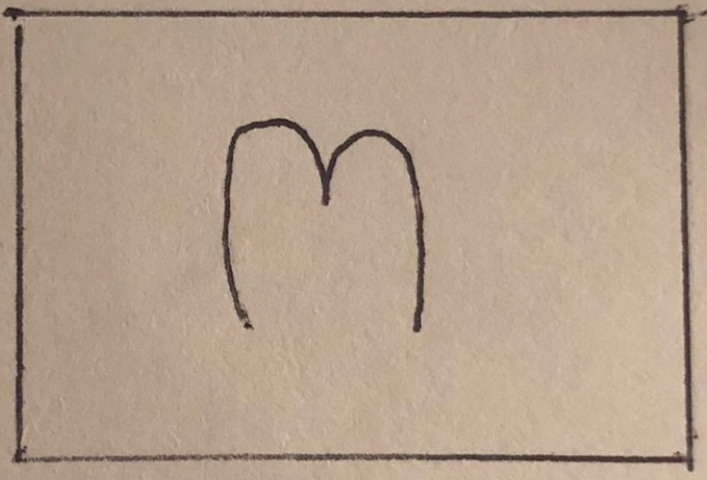
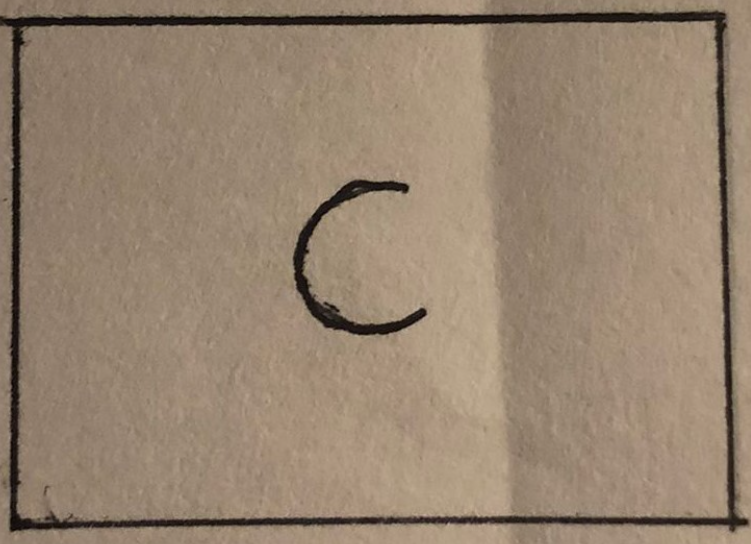


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Load images
marker1 = cv2.imread('images/notebook3/marker1.jpg')
marker2 = cv2.imread('images/notebook3/marker2.jpg')
img1 = cv2.imread('images/notebook3/img1.jpg')


We will manually select the points corresponding to marker 1.

In [ ]:

# Function to order the points selected in the image in the following order: top-left, top-right, bottom-right, bottom-left
def order_points(pts):

	rect = np.zeros((4, 2), dtype = "float64")

	s = pts.sum(axis = 1)
	rect[0] = pts[np.argmin(s)]
	rect[2] = pts[np.argmax(s)]

	diff = np.diff(pts, axis = 1)
	rect[1] = pts[np.argmin(diff)]
	rect[3] = pts[np.argmax(diff)]
	# return the ordered coordinates
	return rect

# Define the callback function for mouse events
def mouse_callback(event, x, y, flags, params):
    # If left button is clicked, record the point coordinates
    if event == cv2.EVENT_LBUTTONDOWN:
        try:
            params['points'].append([x, y])
            cv2.circle(params['img_select_points'], (x, y), 5, (0, 0, 255), -1)
        except:
            print('Invalid input')
            params['points'].pop()
            cv2.circle(params['img_select_points'], (x, y), 5, (0, 0, 0), -1)


# Create a window and set the mouse callback function
def select_points_from_image(img_src, no_of_points=4):
    img_select_points = img_src.copy()
    cv2.namedWindow('image')
    params = {'points': [], 'real_coords': [], 'img_select_points': img_select_points}
    cv2.setMouseCallback('image', mouse_callback, params)

    # Display the image and wait for user to select points
    while True:
        cv2.imshow('image', img_select_points)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        if len(params['points']) == no_of_points:
            break

    selected_pts = np.array(params['points']) 

    # Print the selected points
    print('Selected points:', selected_pts)
    cv2.destroyAllWindows()
    return selected_pts

cornersMarker1 = np.array([[36, 47],
 [672, 46],
 [682, 472],
 [37, 471]], dtype=np.float32)


cornersImg1 =order_points(select_points_from_image(img1, 4))



We tried to use corner detection algorithms to detect the corners, selecting the region of interest to select the right marker but it did not work.

In [ ]:
img_copy = img1.copy()

# Define region of interest
mask = np.zeros_like(img_copy[:,:,0])
height, width = img_copy.shape[:2]
roi_corners = [(0, 0), (width//2, 0), (width//2, height), (0, height)]
#roi_corners = [ (width//2, 0), (width, 0), (width, height), (width//2, height)]

cv2.fillPoly(mask, np.array([roi_corners], dtype=np.int32), (255,255,255))

# Convert image to grayscale
gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)

# Detect corners using FAST corner detection method
fast = cv2.FastFeatureDetector_create(threshold=25)
kp = fast.detect(gray, mask)

# Select the strongest 'maxCorners' corners
kp = sorted(kp, key=lambda x: -x.response)[:4]

# Draw selected corners on image
for i in range(len(kp)):
    x, y = kp[i].pt
    cv2.circle(img_copy, (int(x), int(y)), 5, (0, 255, 0), -1)

# Display image with detected corners
cv2.imshow("Corners", img_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()


Next we will find homography between the marker 1 and the prespective image.

In [ ]:
H, _ = cv2.findHomography(cornersImg1, cornersMarker1)


We will perform warp perspective with a bounding box to control the size of the result image.

In [ ]:
result_height, result_width = img1.shape[:2]
cornersWarped = np.float32([[0, 0], [result_width, 0], [result_width, result_height], [0, result_height]])
cornersWarped = cv2.perspectiveTransform(cornersWarped.reshape(-1, 1, 2), H)
bb = cv2.boundingRect(cornersWarped.astype(int))


A = np.eye(3, dtype=np.float32)
A[0, 2] = -bb[0]
A[1, 2] = -bb[1]

F = np.dot(A, H)
img1_warp = cv2.warpPerspective(img1, F, (bb[2], bb[3]))

img1_window = cv2.resize(img1_warp, (960, 540)) 
cv2.imshow('Warp prespective image',img1_window)
cv2.waitKey(0)
cv2.destroyAllWindows()

We will perform template matching to find marker 1 in the prespective image.

In [ ]:
result_marker1 = img1_warp.copy()
marker1_gray = cv2.cvtColor(marker1, cv2.COLOR_BGR2GRAY)
img1_warp_gray = cv2.cvtColor(img1_warp, cv2.COLOR_BGR2GRAY)
w, h = marker1_gray.shape[::-1]

# Apply template Matching
res = cv2.matchTemplate(img1_warp_gray,marker1_gray,cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = max_loc

bottom_right = (top_left[0] + w , top_left[1] + h)
cv2.rectangle(result_marker1, top_left, bottom_right, (0, 0, 255), 5)

result_marker1_window = cv2.resize(result_marker1, (960, 540)) 
cv2.imshow('Detected point',result_marker1_window)
cv2.waitKey(0)
cv2.destroyAllWindows()


Now we need to perform warp prespective with the second marker in mind to be able to identify it. For this the user needs to identify the corners for the second marker.

In [ ]:
# Resize image to be able to view the image and select the points
scale_percent = 30 # percent of original size
width = int(result_marker1.shape[1] * scale_percent / 100)
height = int(result_marker1.shape[0] * scale_percent / 100)
dim = (width, height)

result = cv2.resize(result_marker1, dim, interpolation = cv2.INTER_AREA)

#select points of marker 2 in previous result image
cornersImg2 = order_points(select_points_from_image(result, 4))
cornersMarker2 = np.array([[ 50, 72],
 [729, 66],
 [740, 551],
 [ 52, 556]], dtype=np.float32)

Now we perform warp prespective to the image with marker 1 identified to identify marker 2 in the image. Here the function was cropping the image so we created a bounding box and translated the image to guarantee the result keeps the full image.

In [ ]:

H2, _ = cv2.findHomography(cornersImg2, cornersMarker2)

# Create a new image with the size of the result image
result_height, result_width = result.shape[:2]
cornersWarped = np.float32([[0, 0], [result_width, 0], [result_width, result_height], [0, result_height]])
cornersWarped = cv2.perspectiveTransform(cornersWarped.reshape(-1, 1, 2), H2)
bb = cv2.boundingRect(cornersWarped.astype(int))


A = np.eye(3, dtype=np.float32)
A[0, 2] = -bb[0]
A[1, 2] = -bb[1]

F = np.dot(A, H2)
warped = cv2.warpPerspective(result, F, (bb[2], bb[3]))
#warped = cv2.warpPerspective(result, H2, (result.shape[1], result.shape[0]))


#show result
result_marker1_warped_window = cv2.resize(warped,  (960, 540)) 
cv2.imshow('Warp prespective image',result_marker1_warped_window)
cv2.waitKey(0)
cv2.destroyAllWindows()



Apply template matching with the second marker.

In [ ]:
result_marker2 = warped.copy()

# Converting images to gray scale
marker2_gray = cv2.cvtColor(marker2, cv2.COLOR_BGR2GRAY)
img1_warp_gray = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
w, h = marker2_gray.shape[::-1]

# Apply template Matching
res = cv2.matchTemplate( img1_warp_gray, marker2_gray, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
top_left = max_loc

bottom_right = (top_left[0] + w , top_left[1] + h)
cv2.rectangle(result_marker2, top_left, bottom_right, (0, 255, 0), 5)

result_window = cv2.resize(result_marker2, (960, 540)) 
cv2.imshow('Detected point',result_window)
cv2.waitKey(0)
cv2.destroyAllWindows()

Finally we will apply the inverse warp prespectives to get the initial image now with the templates identified.

In [ ]:
offset = -4000

print(result_marker2.shape[1] + offset, result_marker2.shape[0] + offset)
# Apply the inverse of the second homography

H_2_inv = np.linalg.inv(H2) # Compute the inverse of H2
H_1_inv = np.linalg.inv(H) # Compute the inverse of H
H_orig = H_2_inv.dot(H_1_inv) # Compute the inverse of H * H2

# Warp the image using the inverse of the homography
final_result = cv2.warpPerspective(result_marker2, H_orig, (result_marker2.shape[1] - offset, result_marker2.shape[0] - offset))

final_result_window = cv2.resize(final_result, (960, 540)) 

cv2.imshow('Final result', final_result_window)

cv2.waitKey(0)

cv2.destroyAllWindows()

Here are the final results: 

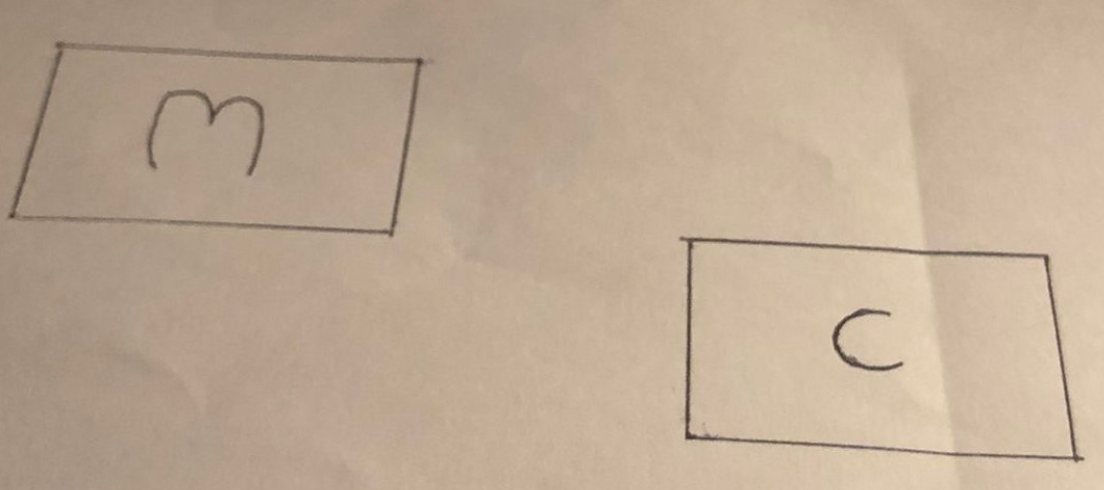
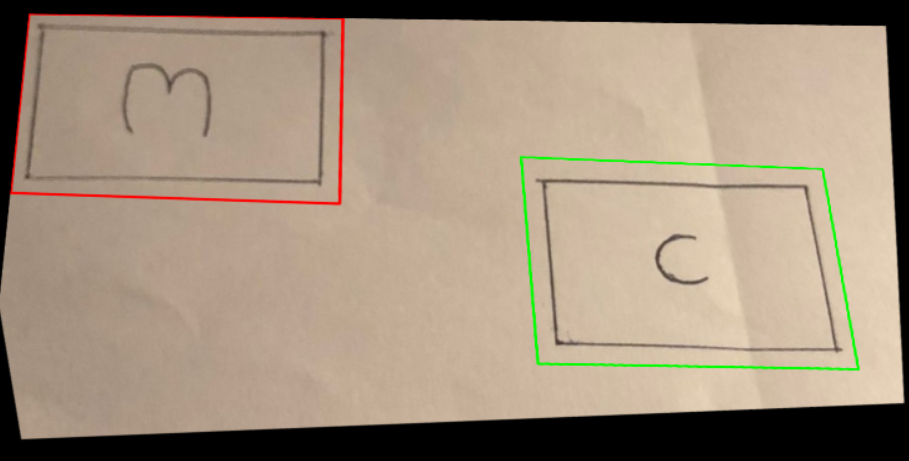
